#### Based on 
https://github.com/avisoori-databricks/Tuning-the-Finetuning
https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms

In [ ]:
%pip install transformers==4.31.0 datasets==2.13.0 peft==0.4.0 accelerate==0.21.0 bitsandbytes==0.40.2 trl==0.4.7

In [ ]:
dbutils.library.restartPython()

In [ ]:
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch
from transformers.trainer_callback import TrainerCallback
import os
from transformers import BitsAndBytesConfig
from trl import SFTTrainer
import mlflow

In [ ]:
%sql
USE description_generator;

In [ ]:
df = spark.sql("SELECT * FROM product_name_to_description").toPandas()
df['text'] = df["prompt"]+df["response"]
df.drop(columns=['prompt', 'response'], inplace=True)
display(df), df.shape

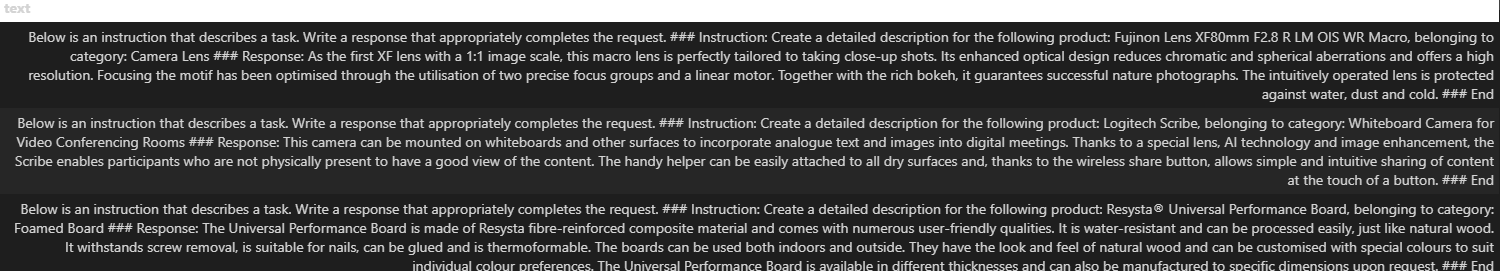

In [ ]:
from datasets import load_dataset
from datasets import Dataset
dataset = Dataset.from_pandas(df).train_test_split(test_size=0.05, seed=42)

In [ ]:
# target_modules = ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head']
#or
target_modules = ['q_proj','v_proj']

lora_config = LoraConfig(
    r=8,#or r=16
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    target_modules = target_modules,
    task_type="CAUSAL_LM",
)

base_dir = "/dbfs/finetuning"

per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = 'adamw_hf'
learning_rate = 1e-5
max_grad_norm = 0.3
warmup_ratio = 0.03
lr_scheduler_type = "linear"


from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir=base_dir,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs = 3.0,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [ ]:
model_path = 'openlm-research/open_llama_3b_v2'
tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [ ]:
model = LlamaForCausalLM.from_pretrained(
    model_path, device_map='auto', load_in_8bit=True,
)

In [ ]:

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 2,662,400 || all params: 3,429,136,000 || trainable%: 0.07764054852300988


In [ ]:
trainer = SFTTrainer(
    model,
    train_dataset=dataset['train'],
    eval_dataset = dataset['test'],
    dataset_text_field="text",
    max_seq_length=256,
    args=training_args,
)
#Upcast layer norms to float 32 for stability
for name, module in trainer.model.named_modules():
  if "norm" in name:
    module = module.to(torch.float32)

In [ ]:
with mlflow.start_run(run_name='Lora_finetune'):
  trainer.train()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
[W reducer.cpp:1300] Warning: find_unused_parame

Epoch,Training Loss,Validation Loss
1,No log,2.054950
2,2.254000,1.905022
3,2.254000,1.898307


/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/local_disk0/.ephemeral_nfs/envs/pythonEnv-f39ac116-74ab-4367-8f31-bfe348a1b9c4/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


#### Some metrics from MLFlow

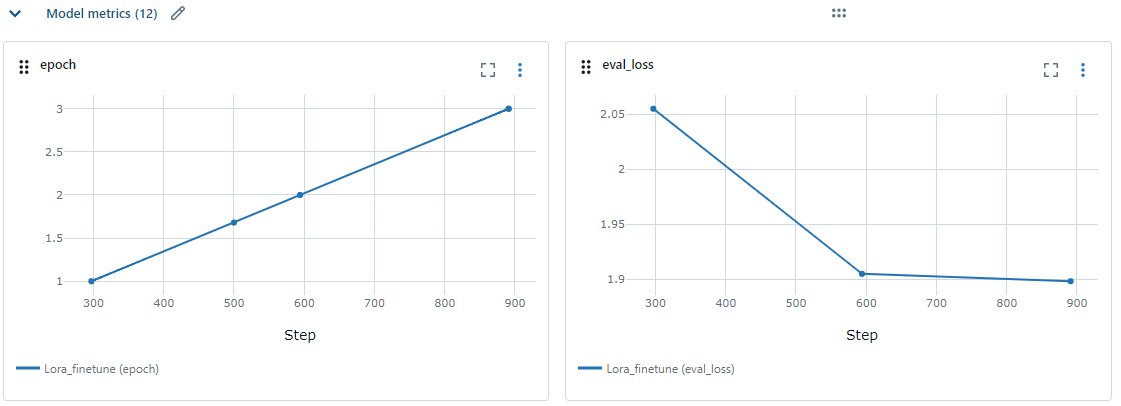

#### Checpoint folder on S3 (dbfs)
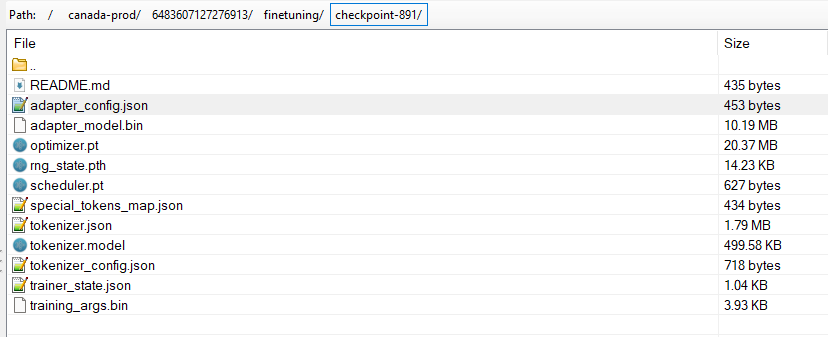
